# Importing Requirements

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
import string
import re
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import pickle
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Fetching Data

Data Contains News Articles from 5 Categories : 
- Sports
- Entertainment
- Politics
- Technology
- Business

In [12]:
df = pd.read_csv('article_train.csv', delimiter=",", encoding='utf-8',on_bad_lines='skip',index_col = 0)

In [13]:
df.head()

,category,content
746,tech,Phone companies are not doing enough to warn c...
1434,business,"The tragedy has left at least 25,000 people de..."
2137,politics,Six government units would also be scrapped un...
1762,business,Bombardier said restructuring plans drawn up b...
348,sport,"J Crane (Sale Harriers Manchester), S Jones (T..."


# Preparing Data for Training

### Cleaning Text data

In [14]:
def clean_text(text,lemmatize_flag):

    stop_words = set(stopwords.words('english'))
    wn = nltk.WordNetLemmatizer() 

    text_split = text.split(" ")
    text_lc = " ".join([word.lower() for word in text_split if word not in string.punctuation and word not in stop_words]) # remove puntuation ans stopwords

    text_rc = re.sub('[0-9]+', '', text_lc)

    if lemmatize_flag == True :
        
        text_split = text_rc.split(" ")
        text = " ".join([wn.lemmatize(word) for word in text_split if word not in stop_words])  # remove stopwords and lemmetizing
    
        return text

    else:
      
        return text_rc

### Data Preparation

In [21]:
def data_prep(lemmatize_flag, dim_reduction_algo):
    
    data = pd.read_csv('article_train.csv', delimiter=",", encoding='utf-8',on_bad_lines='skip',index_col = 0)
    #data = data.sample(sample_size, replace=True)

    # Text Cleaning
    clean_data = []
    for text in list(data['content']):
        clean = clean_text(str(text),lemmatize_flag)
        clean_data.append(clean) 
        
    #print(clean_data)
    print("Data Cleaned")

    # Converting to Embeddings
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    embeddings = list(model.encode(clean_data))

    print("Text converted to Embeddings")
    #print(embeddings)
    #print(type(embeddings))

    if dim_reduction_algo == 'UMAP':
        # Dimentionality Reduction (UMAP)
        embedding_model = umap.UMAP(n_neighbors=15, 
                                n_components=5, 
                                metric='cosine')
             
        
    elif dim_reduction_algo == 'PCA':
        # Dimentionality Reduction (PCA)
        embedding_model = PCA(n_components=5)
        
    else:
        # Dimentionality Reduction (UMAP)---> Default
        embedding_model = umap.UMAP(n_neighbors=15, 
                                n_components=5, 
                                metric='cosine')
        
        
    processed_embeddings = embedding_model.fit_transform(embeddings)
        
        
    print("Embeddings Processed")    
    #print(processed_embeddings)
    #print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")  
    #print(type(umap_embeddings))

    with open('embeddings_model', 'wb') as files:
        pickle.dump(embedding_model, files)
    
    list_embeddings = [list(x) for x in embeddings]
    list_processed_embeddings = [list(x) for x in processed_embeddings]

    # print("UMAP Embeddings")
    # print(umap_embeddings)
    # print(type(umap_embeddings))
    #print("UMAP Embeddings List")
    #print(list_processed_embeddings)
    #print(type(list_processed_embeddings))

    data['clean_data'] = clean_data
    data['embeddings'] = list(list_embeddings)
    data['processed_embeddings'] = list(list_processed_embeddings)

    data.to_csv('data_for_training_new.csv')
    
    return data

In [22]:
training_data = data_prep(lemmatize_flag = False, dim_reduction_algo = 'PCA')

Data Cleaned
Text converted to Embeddings
Embeddings Processed


# Training (HDBSCAN Clustering + Keywords Extraction)

### HDBSCAN Model

In [27]:
def hdbscan_model(training_data):

    try:
        processed_embeddings = list(training_data['processed_embeddings'])
        #print(processed_embeddings)
        cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                            metric='euclidean',                      
                            cluster_selection_method='eom',prediction_data=True).fit(processed_embeddings)

        with open('hdbscan_model', 'wb') as files:
            pickle.dump(cluster, files)

        return "Model Trained and Saved !!!"
  
    except Exception as e:

        return "Exception" + str(e)

In [28]:
training_data = pd.read_csv('data_for_training_new.csv',converters = {'processed_embeddings' : pd.eval})

In [29]:
training_data.head()

,Unnamed: 0,category,content,clean_data,embeddings,processed_embeddings
0,746,tech,Phone companies are not doing enough to warn c...,phone companies enough warn customers internet...,"[0.013306754, 0.024846394, 0.002615778, -0.041...","[-0.23093216633607697, 0.10992257008348151, 0...."
1,1434,business,"The tragedy has left at least 25,000 people de...","the tragedy left least , people dead, sri lank...","[0.0038533085, 0.052527506, -0.02640235, 0.040...","[-0.15286212130407625, 0.08335930530391002, -0..."
2,2137,politics,Six government units would also be scrapped un...,six government units would also scrapped propo...,"[-0.020874929, 0.060556654, 0.0249074, 0.01048...","[0.08611974584322751, 0.5650162473745363, 0.02..."
3,1762,business,Bombardier said restructuring plans drawn up b...,bombardier said restructuring plans drawn mr t...,"[-0.0006105879, 0.06337664, -0.007544919, 0.07...","[-0.04106615372518025, 0.07486939003450954, -0..."
4,348,sport,"J Crane (Sale Harriers Manchester), S Jones (T...","j crane (sale harriers manchester), s jones (t...","[-0.04700164, -0.0639302, -0.0005907867, 0.044...","[0.4222796617643011, -0.21070047478006415, -0...."


In [30]:
hdbscan_model(training_data)

'Model Trained and Saved !!!'

### Visualize Clusters (By Processing Dmbeddings and Plotting in 2 Dimensions)

In [40]:
def visualize(training_data):
    
    training_data = pd.read_csv('data_for_training_new.csv',converters = {'processed_embeddings' : pd.eval,'embeddings' : pd.eval})

    embeddings = list(training_data['embeddings'])

    # load saved model
    with open('hdbscan_model' , 'rb') as f:
        cluster = pickle.load(f)
    
    # Prepare data
    #processed_embeddings = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    processed_embeddings = PCA(n_components=2).fit_transform(embeddings)
    result = pd.DataFrame(processed_embeddings, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()

    return plt.show()

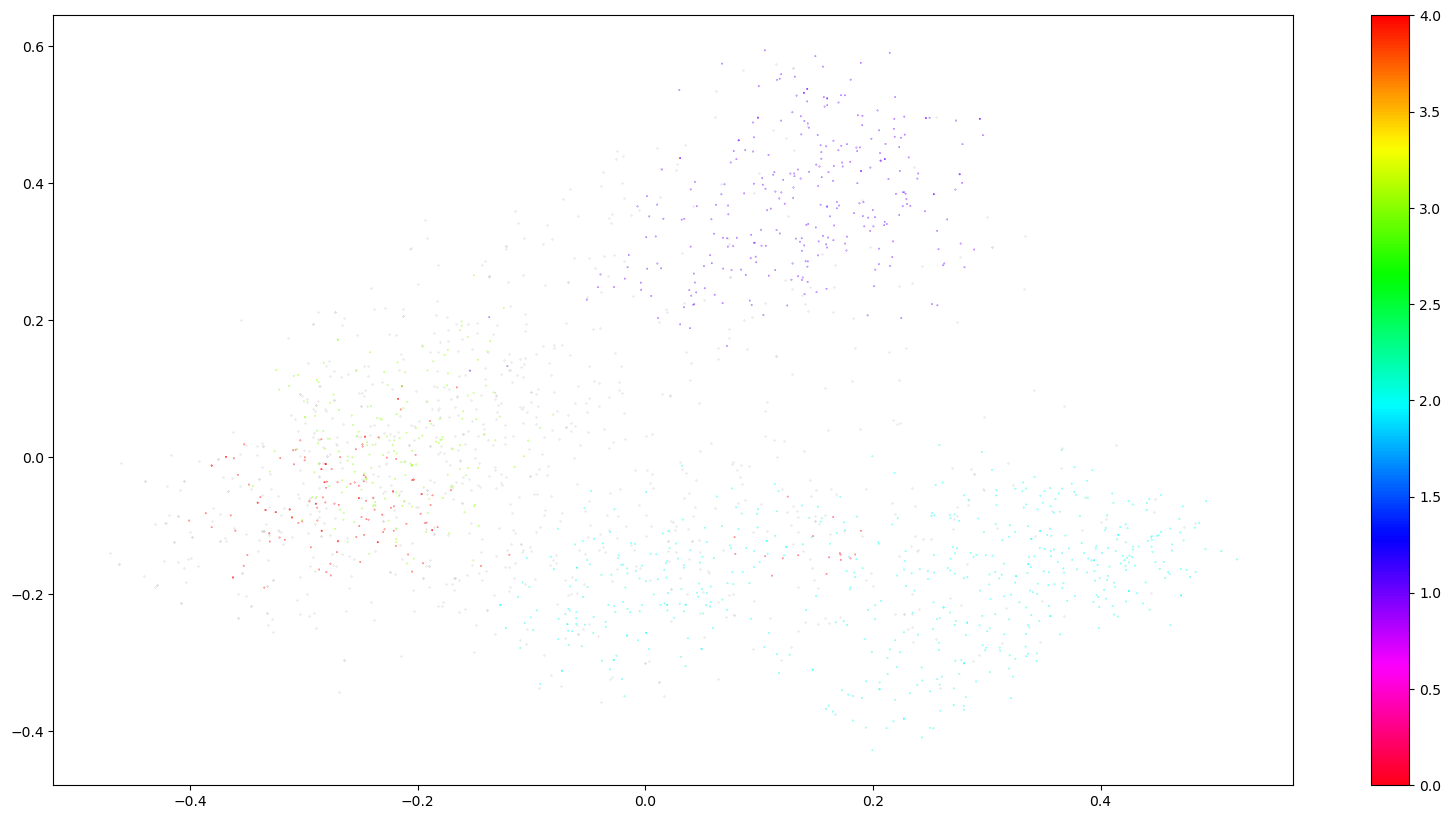

In [41]:
visualize(training_data)

Here, it can be seen that most of the clustered data points are distinct, but at some places there seems to be an overlap

In [33]:
def hdbscan_single_linkage():
    with open('hdbscan_model' , 'rb') as f:
        cluster = pickle.load(f)
    cluster.condensed_tree_.plot(select_clusters=True)
    return "Single Linkage Tree"

'Single Linkage Tree'

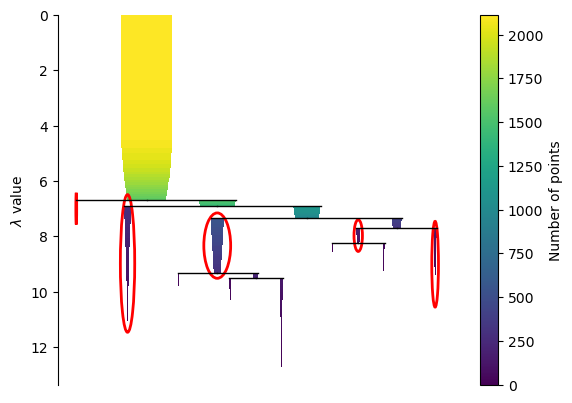

In [37]:
hdbscan_single_linkage()

### Topic Creation/Keyword extraction

In [35]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .content
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "content": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    # top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_n_words = {label: " ".join([words[j] for j in indices[i]][::-1]) for i, label in enumerate(labels)}
    return top_n_words

def topic_info_creation(training_data):

    # Loading Model
    with open('hdbscan_model' , 'rb') as f:
        cluster = pickle.load(f)
    # 
    training_data['content'] = training_data['content'].astype('str')
    docs_df = pd.DataFrame(training_data)
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'content': ' '.join})

    tf_idf, count = c_tf_idf(docs_per_topic.content.values, m=len(training_data))

    #Extraction Topic Count
    topics_count = extract_topic_sizes(training_data)

    #Extraction Topic description
    dictionary = extract_top_words_per_topic(tf_idf, count, docs_per_topic, n=10)

    # Outliers
    dictionary[-1] = 'Outliers'

    topics_desc = pd.DataFrame.from_dict(dictionary,orient='index',columns = ['topic_description']).reset_index()
    topics_desc.rename(columns = {'index':'Topic'},inplace = True)


    #Merging the two dataframes
    topic_info = pd.merge(topics_count,topics_desc,on = 'Topic',how = 'inner')

    topics_desc.to_csv('topic_info.csv')


    return topic_info


In [36]:
topic_info_creation(training_data)

,Topic,Size,topic_description
0,-1,935,Outliers
1,2,553,win england best film second cup play ireland ...
2,1,296,labour blair party election brown howard gover...
3,3,174,yukos bank economy growth economic shares chin...
4,4,138,search net users software tv computer microsof...
5,0,17,kenteris thanou greek iaaf tests doping olympi...


#### **Model Parameters :**

- **Dim Red : PCA (n_components = 5)**
- **HDBSCAN : min_cluster_size=15, metric='euclidean',cluster_selection_method='eom'**



The HDBScan model has Clustering the data into 5 categories excluding the outliers. 
And if we closely look at the topic descriptions, it can be seen that Topic 1 , Topic 3, Topic 4 clearly translates to politics, business and technology categories respectively, 
but there seems to be an overlap between Topic 2 and Topic 0 which combines the entertainment and sports categories

It can also be seen that a lot of samples have been added to the Outliers

## Training the Model with Different Model Configurations

#### **Model Parameters :**

- **Dim Red : UMAP(n_neighbors=15, n_components=5, metric='cosine'))**
- **HDBSCAN : min_cluster_size=15, metric='euclidean',cluster_selection_method='eom'**

In [44]:
def data_prep(lemmatize_flag, dim_reduction_algo):
    
    data = pd.read_csv('article_train.csv', delimiter=",", encoding='utf-8',on_bad_lines='skip',index_col = 0)
    #data = data.sample(sample_size, replace=True)

    # Text Cleaning
    clean_data = []
    for text in list(data['content']):
        clean = clean_text(str(text),lemmatize_flag)
        clean_data.append(clean) 
        
    #print(clean_data)
    print("Data Cleaned")

    # Converting to Embeddings
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    embeddings = list(model.encode(clean_data))

    print("Text converted to Embeddings")
    #print(embeddings)
    #print(type(embeddings))

    if dim_reduction_algo == 'UMAP':
        # Dimentionality Reduction (UMAP)
        embedding_model = umap.UMAP(n_neighbors=15, 
                                n_components=5, 
                                metric='cosine')
             
        
    elif dim_reduction_algo == 'PCA':
        # Dimentionality Reduction (PCA)
        embedding_model = PCA(n_components=5)
        
    else:
        # Dimentionality Reduction (UMAP)---> Default
        embedding_model = umap.UMAP(n_neighbors=15, 
                                n_components=5, 
                                metric='cosine')
        
        
    processed_embeddings = embedding_model.fit_transform(embeddings)
        
        
    print("Embeddings Processed")    
    #print(processed_embeddings)
    #print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")  
    #print(type(umap_embeddings))

    with open('embeddings_model_umap', 'wb') as files:
        pickle.dump(embedding_model, files)
    
    list_embeddings = [list(x) for x in embeddings]
    list_processed_embeddings = [list(x) for x in processed_embeddings]

    # print("UMAP Embeddings")
    # print(umap_embeddings)
    # print(type(umap_embeddings))
    #print("UMAP Embeddings List")
    #print(list_processed_embeddings)
    #print(type(list_processed_embeddings))

    data['clean_data'] = clean_data
    data['embeddings'] = list(list_embeddings)
    data['processed_embeddings'] = list(list_processed_embeddings)

    data.to_csv('data_for_training_new_umap.csv')
    
    return data

In [45]:
training_data = data_prep(lemmatize_flag = False, dim_reduction_algo = 'UMAP')

Data Cleaned
Text converted to Embeddings
Embeddings Processed


In [47]:
def hdbscan_model(training_data):

    try:
        processed_embeddings = list(training_data['processed_embeddings'])
        #print(processed_embeddings)
        cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                            metric='euclidean',                      
                            cluster_selection_method='eom',prediction_data=True).fit(processed_embeddings)

        with open('hdbscan_model_2', 'wb') as files:
            pickle.dump(cluster, files)

        return "Model Trained and Saved !!!"
  
    except Exception as e:

        return "Exception" + str(e)

In [48]:
hdbscan_model(training_data)

'Model Trained and Saved !!!'

In [65]:
def visualize(training_data):
    
    training_data = pd.read_csv('data_for_training_new_umap.csv',converters = {'processed_embeddings' : pd.eval,'embeddings' : pd.eval})

    embeddings = list(training_data['embeddings'])

    # load saved model
    with open('hdbscan_model_2' , 'rb') as f:
        cluster = pickle.load(f)
    
    # Prepare data
    processed_embeddings = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    #processed_embeddings = PCA(n_components=2).fit_transform(embeddings)
    result = pd.DataFrame(processed_embeddings, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()

    return plt.show()

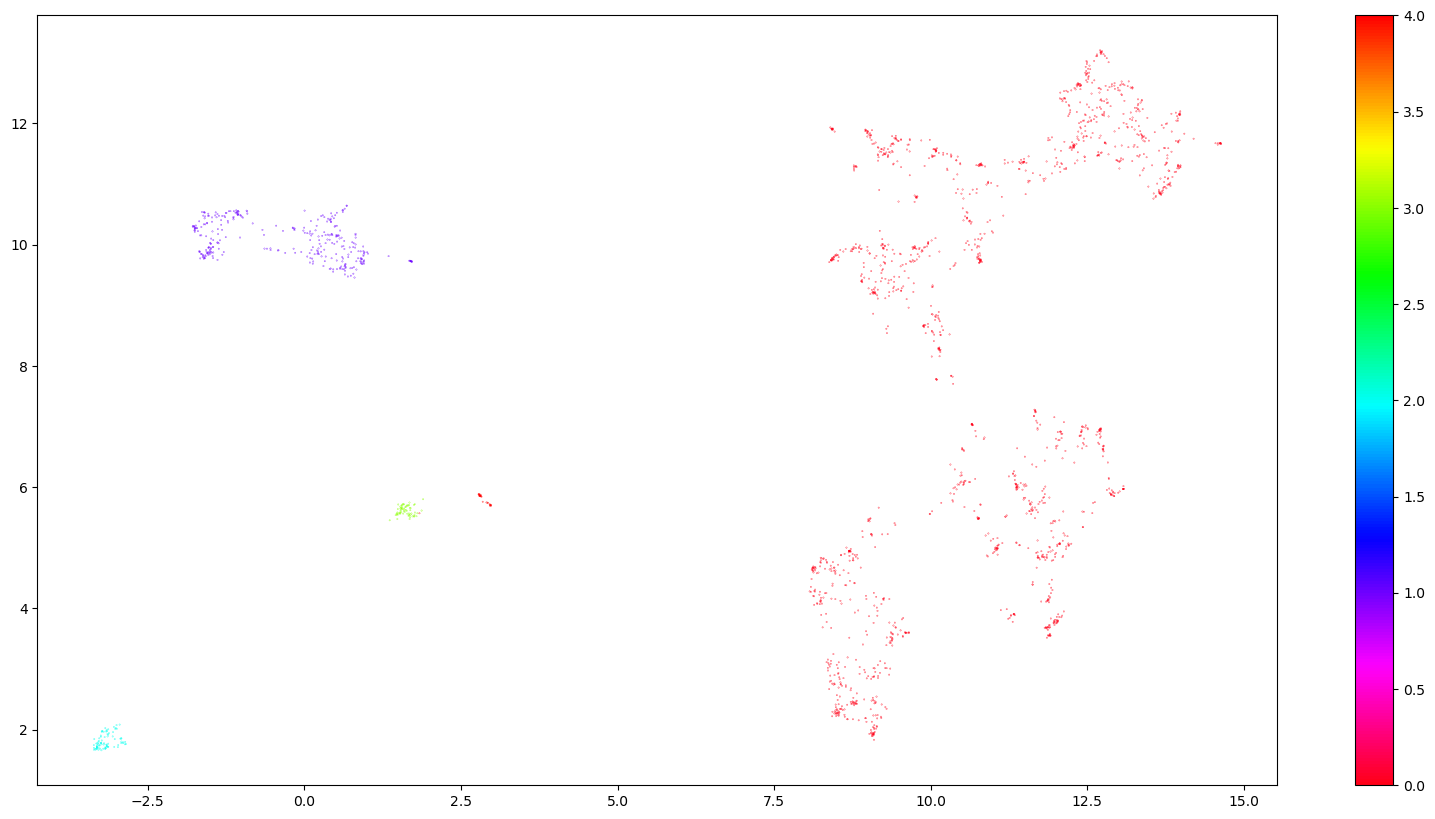

In [66]:
visualize(training_data)

In [51]:
def hdbscan_single_linkage():
    with open('hdbscan_model_2' , 'rb') as f:
        cluster = pickle.load(f)
    cluster.condensed_tree_.plot(select_clusters=True)
    return "Single Linkage Tree"

'Single Linkage Tree'

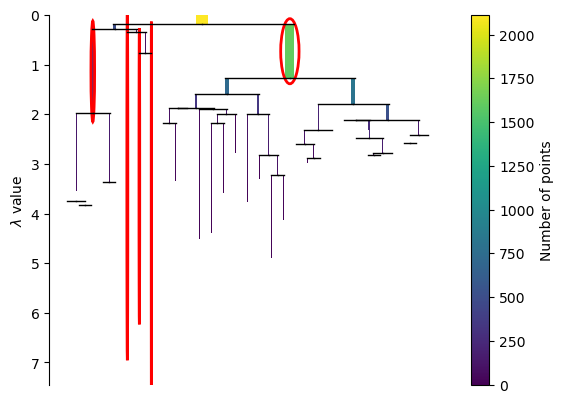

In [52]:
hdbscan_single_linkage()

In [53]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .content
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "content": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    # top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_n_words = {label: " ".join([words[j] for j in indices[i]][::-1]) for i, label in enumerate(labels)}
    return top_n_words

def topic_info_creation(training_data):

    # Loading Model
    with open('hdbscan_model_2' , 'rb') as f:
        cluster = pickle.load(f)
    # 
    training_data['content'] = training_data['content'].astype('str')
    docs_df = pd.DataFrame(training_data)
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'content': ' '.join})

    tf_idf, count = c_tf_idf(docs_per_topic.content.values, m=len(training_data))

    #Extraction Topic Count
    topics_count = extract_topic_sizes(training_data)

    #Extraction Topic description
    dictionary = extract_top_words_per_topic(tf_idf, count, docs_per_topic, n=10)

    # Outliers
    dictionary[-1] = 'Outliers'

    topics_desc = pd.DataFrame.from_dict(dictionary,orient='index',columns = ['topic_description']).reset_index()
    topics_desc.rename(columns = {'index':'Topic'},inplace = True)


    #Merging the two dataframes
    topic_info = pd.merge(topics_count,topics_desc,on = 'Topic',how = 'inner')

    topics_desc.to_csv('topic_info_2.csv')


    return topic_info


In [54]:
topic_info_creation(training_data)

,Topic,Size,topic_description
0,0,1615,government people film uk music labour best ne...
1,1,322,england club ireland wales chelsea rugby game ...
2,2,85,roddick open australian seed nadal henman tenn...
3,3,65,race indoor olympic championships holmes athen...
4,4,26,kenteris thanou doping greek iaaf conte drugs ...


Here, even though there are no out liers present, it can be seen there is clearly and overlap of topics between all the topics. So for this particular usecase is can be seen that the model with embedding reduced using PCA seems to perform much better.

However, some other iterations of testing by tuning the hyperparameters for UMAP(n_neighbors, n_components, etc) can be performed and compared

Currently we will be going forward with the PCA model.


# Prediction Script

In [87]:
#sentence transformer model
transformer_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

with open('transformer_model', 'wb') as files:
    
    pickle.dump(transformer_model, files)

#dim reduction transformer model
with open('embeddings_model' , 'rb') as f:
      embeddings_model = pickle.load(f)
        
#hdbscan model
with open('hdbscan_model' , 'rb') as f:
          cluster = pickle.load(f)

In [86]:
def cluster_prediction(text):
    
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    
    embeddings = list(model.encode([text]))

    # Dimentionality Reduction (UMAP)
    processed_embeddings = embedding_model.transform(embeddings)
    
    with open('embeddings_model' , 'rb') as f:
        
        embeddings_model = pickle.load(f)
    
    with open('hdbscan_model' , 'rb') as f:
        
        cluster = pickle.load(f)

    topics = set(list(cluster.labels_))

    test_labels, strengths = hdbscan.approximate_predict(cluster, processed_embeddings)

    topic = test_labels[0]

    df = pd.read_csv('topic_info.csv')

    #print(df)
    
    df = df[df['Topic']==topic]

    description = list(df['topic_description'])[0]
    
    result = {'topic' : topic, 'description':description}

    return result

In [85]:
cluster_prediction('''When I'm at home, I get distracted by all sorts of things but for the five days I was in London, I was in a pressurised situation, but I found it easy to relax by running.The bid chairman, Lord Coe, admitted he would never dream of running a marathon, even though he was an Olympic middle-distance runner.When I was in London I did all of my runs on the treadmill, which isn't the same as exercising outdoors.But the only person who was positive about my intentions was Tanni Grey Thompson, who has won the London Marathon wheelchair race six times.It was good to get out on the road for my long run on Sunday.Even though it was a very busy week entertaining the International Olympic Committee's (IOC) Evaluation Commission, I actually found my running schedule easier to follow.And because it was a rest day I didn't have to feel bad about missing my training either.It was back to official duties last week in my role as an ambassador to London's 2012 Olympic bid.But I coped with it very well and, even though it was bitterly cold, I put in 15-and-a-half miles - only another 11 to go then.After the week I'd had I was a bit concerned I wouldn't be able to complete it.''')

{'topic': 2,
 'description': 'win england best film second cup play ireland won game'}